# **Tarea 1:** EDA y modelos bayesianos
## **Grupo 5** 
## **Integrantes:** 
 * Diego Irarrazaval
 * Pablo Paredes
 * Tomas Rojas

## Pregunta 1:  Carga y limpieza de datos.
### P1.1

In [1]:
import pandas as pd
import glob as glob
import numpy as np
import math

`files_raw`, `files_estadisticas` y `files_asignacion` son listas que contienen las direcciones donde se encuentran los .csv a leer. 

In [2]:
files_raw = glob.glob('data/raw/**/*.csv', recursive = True)
files_estadisticas = glob.glob('data/estadisticas_upz/*.csv')
files_asignacion = glob.glob('data/asignacion_upz/*.csv')
files_estadisticas.sort()
data_raw = ([pd.read_csv(dir) for dir in files_raw])

### Creación del DataFrame y reporte de archivos furnished

In [3]:
'''
Creamos un data frame 'furnished', el cual tendrá dos columnas
1) 'url' para hacer el merge finalmente y obtener el data frame requerido
2) 'furnished' para contar cuantos datos están en archivos furnished y no en archivos all
'''

data_all = []
data_fur = []

for i in [0,2,4,6,8]:
    
    df1 = pd.read_csv(files_raw[i])
    df2 = pd.read_csv(files_raw[i+1])
    
    data_all.append(df1)
    data_fur.append(df2)
    
df_all = pd.concat(data_all)
df_fur = pd.concat(data_fur)
    
f1 = pd.merge(df_all, df_fur, how='outer', on='url', indicator='furnished')
furnished = f1[['url', 'furnished']].copy()

furnished.drop_duplicates(inplace = True)
furnished.reset_index(drop=True, inplace=True)

# Se reportan si hay datos de archivos furnished que no estén en all 

print('Hay '+ str(len(furnished[furnished['furnished'] == 'right_only'])) + ' datos de archivos furnished que no estan en all')

Hay 13026 datos de archivos furnished que no estan en all


In [4]:
'''
Creamos el data frame 'data'
'''

df_aux = pd.concat([df_all, df_fur], ignore_index=True)

data = pd.merge(df_aux, furnished, how='inner', on='url')
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

# Se elimina la columna 'furnished' y se quitan los duplicados

data.drop('furnished', axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

### P1.2 Limpieza de Columnas 

In [5]:
'''
Limpieza de columnas 'price', 'surface', 'n_rooms', 'n_bath'
'''

# Columna de precio ('price') tipo float

data.price = data['price'].str.replace('.', '')
data.price = data['price'].str.strip('$')
data.price = data['price'].map(float)

# Columna de área ('surface') tipo float

data.surface = data['surface'].replace('m2', '', regex=True)
data.surface = data['surface'].map(float)

In [6]:
# Notamos que en la columna de dormitorios ('n_rooms') existe la opción '5+'
# por lo que dejaremos esta columna como categórica

data.n_rooms.unique()

array([3.0, '3', 5.0, '5', 4.0, '4', 2.0, '2', 1.0, '1', nan, '5+'],
      dtype=object)

In [7]:
# Se crea un diccionario para pasar los datos numéricos de 'n_rooms' a string
# y se efectúa el mapeo

dic = {1.0: '1', 2.0:'2', 3.0: '3', 4.0:'4', 5.0:'5', math.nan: '0'}

data.n_rooms = data['n_rooms'].replace(dic)

In [8]:
# Como habían datos que solo se diferenciaban en la cantidad de dormitorios
# por el tipo de dato que eran (float o int), puede haberse creado duplicados. Se borran nuevamente los duplicados
# de data

data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
data.n_rooms.unique()

array(['3', '5', '4', '2', '1', '0', '5+'], dtype=object)

In [9]:
# Se hace lo mismo con la columnna de cantidad de baños ('n_bath')

data.n_bath.unique()

array([2.0, '2', 3.0, '3', 5.0, '5', 4.0, '4', 1.0, '1', nan, '5+'],
      dtype=object)

In [10]:
import math
dic = {1.0: '1', 2.0:'2', 3.0: '3', 4.0:'4', 5.0:'5', math.nan: '0'}

data.n_bath = data.n_bath.replace(dic)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
data.n_bath.unique()

array(['2', '3', '5', '4', '1', '0', '5+'], dtype=object)

In [11]:
len(data)

16303

In [12]:
'''
Separación de columna property_tipe|rent_type|location en tres columnas
con los nombres respectivos

'''

# Renombramos la columna

data.columns = ['PTL', 'price', 'n_rooms', 'n_bath', 'surface', 'details', 'url', 'metrocuadrado_index']

In [13]:
# Creamos las columnas y las llenamos

col = data['PTL'].str.split(', ', expand=True)

meta_col = col[0].str.split(' en ', expand=True)

# Nos aseguramos que hayan solo las siguientes opciones:
# -> 'Casa', 'Apartamento' para property_type
# -> 'Arriendo', 'Venta Y Arriendo' para rent_type

print(meta_col[0].unique())
print(meta_col[1].unique())

['Casa' 'Apartamento']
['Arriendo' 'Venta Y Arriendo']


In [14]:
# Formamos las nuevas columnas 'property_type', 'rent_type', 'location'

data['property_type'] = meta_col[0] 
data['rent_type'] = meta_col[1]
data['location'] = col[1]

# y retiramos la columna PTL

data.drop('PTL', axis=1, inplace=True)

In [15]:
# Finalmente quitamos la ciudad de 'location'

loc = col[1].str.split(' Bogotá', expand=True)
data.location = loc[0]

### P1.3 Precio por metro cuadrado y Cantidad de garages

In [16]:
'''
Agregamos una columna que represente el precio por metro cuadrado 'price_per_m2'

'''

data['price_per_m2'] = np.where(data['surface'] <= 0, float('nan'), data['price']/data['surface'])


In [17]:
'''
Obtenemos la cantidad de garajes y lo agregamos como columna también 'cant_garajes'

'''

garajes_list = data.url.str.split('-garajes', expand=True)
garajes_num = garajes_list[0].str.rsplit('-', n=1, expand=True)

# indices que tienen urls con info de la cantidad de garajes
ind = garajes_list[1].index[garajes_list[1].isna() == False]

# generación de nueva columna para después asignarla a la data
garajes_list[2] = np.nan
garajes_list[2].loc[ind] = garajes_num[1].loc[ind]

# agregación de la cantidad de garajes a la data (nan si no hay info)
data['cant_garajes'] = garajes_list[2]
data['cant_garajes'] = data['cant_garajes'].fillna(0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### P1.4 Clasificación Tipo de Producto

In [18]:
'''
Creamos una nueva columna 'clasif_prod_type' donde se representará la clasificación
de la vivienda con dígitos del 1 al 8 de acuerdo al enunciado

'''

data['clasif_prod_type'] = np.nan

data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 80) & (data.surface < 120)] = 1
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 120) & (data.surface < 180)] = 2
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 180) & (data.surface < 240)] = 3
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 240) & (data.surface < 360)] = 4
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 360) & (data.surface < 460)] = 5
#data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 360)] = 5
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 40) & (data.surface < 60)] = 6
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 60) & (data.surface < 80)] = 7
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 80)& (data.surface < 120)] = 8
#data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 80)] = 8 #& (data.surface < 120)] = 8
data['clasif_prod_type'].astype('category')

0        1.0
1        NaN
2        NaN
3        NaN
4        2.0
        ... 
16298    NaN
16299    NaN
16300    NaN
16301    8.0
16302    NaN
Name: clasif_prod_type, Length: 16303, dtype: category
Categories (8, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

### P1.5 Obtención del código UPZ

In [19]:
'''
Se carga el archivo y se guarda en un dataframe data_upz
Luego, se realiza el merge para obtener el código para cada barrio

'''

# Se guarda la base de datos en un data frame
data_upz = pd.read_csv(files_asignacion[0], usecols = ['UPlCodigo', 'pro_location', 'UPlArea'])

# Se deja todo en minuscula para poder hacer el merge correctamente
data_upz.pro_location = data_upz.pro_location.map(str).map(lambda s: s.lower())
data.location = data.location.map(lambda s: s.lower())

In [20]:
#Se realiza el merge y se reportan cuantos datos no fueron asignados con código UPZ

data_merge = pd.merge(data, data_upz, left_on='location', right_on='pro_location', how='left')

print('A ' + str(sum(data_merge.UPlCodigo.isna())) + ' datos no se les puede asignar código UPZ')
print('lo cual es ' + str(sum(data_merge.UPlCodigo.isna())/len(data)*100) + '% de los datos')

A 1945 datos no se les puede asignar código UPZ
lo cual es 11.930319573084708% de los datos


In [21]:
# Creamos la columna 'UPZ' en data y le asignamos el código UPZ obtenido en data_merge

data['UPZ'] = data_merge['UPlCodigo']
data['UPZ_area'] = data_merge['UPlArea']

### P1.6 Fusión de datos con código UPZ

In [22]:
'''
Se cargan los datos en distintos data frames, para después hacerles merge con data
Luego, se crea una columna de densidad poblacional para cada código UTZ

'''

# Se cargan los datos en data frames respectivamente

data_pobl = pd.read_csv(files_estadisticas[0])
data_inseg = pd.read_csv(files_estadisticas[1])
data_verde = pd.read_csv(files_estadisticas[2])

In [23]:
data_pobl.head()

,Unnamed: 0,upz,nomupz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,0,UPZ11,SAN CRISTOBAL NORTE,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,1,UPZ12,TOBERIN,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,2,UPZ13,LOS CEDROS,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,3,UPZ18,BRITALIA,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,4,UPZ19,EL PRADO,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [24]:
# Se quitan las columnas innecesarias de data_pobl y data_inseg

data_pobl.drop(['Unnamed: 0', 'nomupz'], axis=1, inplace=True)
data_inseg.drop(['Unnamed: 0', 'UPlNombre2'], axis=1, inplace=True)

In [25]:
# En data_verde se tiene que al código UPZ viene solo el número
# por lo tanto, hay que transformarlo al formato UPZ + número para poder hacer el merge correctamente

col = data_verde.cod_upz.map(int).map(str)
col_upz = 'UPZ' + col

data_verde.cod_upz = col_upz

# Se eliminan las columnas innecesarias
data_verde.drop(['Unnamed: 0', 'upz'], axis=1, inplace=True)

In [26]:
# Se realiza el merge, eliminando después las columnas innecesarias

data = pd.merge(data, data_pobl, left_on='UPZ', right_on='upz', how='left')
data.drop('upz', axis=1, inplace=True)
data = pd.merge(data, data_inseg, left_on='UPZ', right_on='UPlCodigo', how='left')
data.drop('UPlCodigo', axis=1, inplace=True)
data = pd.merge(data, data_verde, left_on='UPZ', right_on='cod_upz', how='left')
data.drop('cod_upz', axis=1, inplace=True)

In [27]:
# Finalmente, se crea la columna de densidad de población para cada código UTZ ('UTZ_density')


data['UTZ_density'] =np.where(data.UPZ_area <=0, math.nan, data.personas/data.UPZ_area)

## P2. EDA
### P2.1 Creacion de `estilo()`

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
#se crea diccionario que dará los valores a setear por defecto en el notebook
custom = {
    "font.size": 12,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,
    "axes.linewidth": 1.25,
    "grid.linewidth": 1,
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "patch.linewidth": 1,
    "xtick.major.width": 1.25,
    "ytick.major.width": 1.25,
    "xtick.minor.width": 1,
    "ytick.minor.width": 1,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    #'figure.figsize':(10.,8.),
    "figure.facecolor": "white",
    "axes.labelcolor": ".15",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": ".15",
    "ytick.color": ".15",
    "axes.axisbelow": True,
    "grid.linestyle": "--",
    "text.color": ".1",
    "patch.force_edgecolor": True,
    "image.cmap": "RdBu_r",
    "xtick.top": False,
    "ytick.right": False,
         }

#En las siguiente línea se implementa el diccionario personalizado como default para este notebook en seaborn
sns.set(rc=custom)

#se escoge una de las paletas que vienen con seaborn 
#(distinta a la que se usa por defecto) para el resto de notebook.
#sns.set_palette('Set2')

### P2.2 Perfilamiento: 
#### Naturaleza de las variables:
Antes del perfilamiento se hara un estudio de la naturaleza de las variables y se observaran algunas columnas 
para mejor entendimiento de los datos. 
Adicionalmente a estos estudios, se realizo lo siguiente:
```
import pandas_profiling as pp
pp.ProfileReport(data)

profile = data.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")
```
No se incluye en el notebook por el tipo de output que genera y debido a que tiene un largo tiempo de ejecucion. 

En primer lugar, es importante conocer que tipos de datos tienen las variables (o columnas).

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16305 entries, 0 to 16304
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price                                    16305 non-null  float64
 1   n_rooms                                  16305 non-null  object 
 2   n_bath                                   16305 non-null  object 
 3   surface                                  16305 non-null  float64
 4   details                                  16195 non-null  object 
 5   url                                      16305 non-null  object 
 6   metrocuadrado_index                      16305 non-null  float64
 7   property_type                            16305 non-null  object 
 8   rent_type                                16305 non-null  object 
 9   location                                 16305 non-null  object 
 10  price_per_m2                             16289

Para comprender mejor las variables, se visualizan las primeras 5 filas con `head()`:

In [30]:
data.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,property_type,rent_type,location,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,UTZ_density
0,3930000.0,3,2,100.00,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,Casa,Arriendo,ciudad salitre sur-oriental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1300000.0,3,2,72.00,"hermosa casa en venta y en arriendo en, mandal...",https://www.metrocuadrado.com/inmueble/venta-c...,41.4,Casa,Venta Y Arriendo,bellavista,...,112706.0,1.8,3.9,25.9,15.9,36.795481,28.607528,7.835821,51.397607,0.020969
2,1800000.0,3,3,76.81,Estrato 4. CASA TRIPLEX!! Exterior . Cuenta co...,https://www.metrocuadrado.com/inmueble/arriend...,41.3,Casa,Arriendo,portales del norte,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145000000.0,3,2,77.00,"Casa esquinera, de tres niveles, se venden mue...",https://www.metrocuadrado.com/inmueble/venta-c...,62.5,Casa,Venta Y Arriendo,urbanizacion sabana de tibabuyes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4200000.0,3,5,176.00,"Casa Amoblada con excelente iluminación, cuent...",https://www.metrocuadrado.com/inmueble/arriend...,51.5,Casa,Arriendo,conejera,...,53837.0,0.0,30.2,8.2,81.4,47.033692,5.814843,4.968944,21.568301,0.033795


Para ayudar a entender las variables numericas:

In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,16305.0,8.411722e+06,1.297305e+08,0.000000,1.600000e+06,2.500000e+06,4.000000e+06,7.800000e+09
surface,16305.0,1.177417e+02,1.143719e+02,0.000000,5.800000e+01,7.840000e+01,1.300000e+02,7.400000e+03
metrocuadrado_index,16305.0,5.279873e+01,1.380071e+01,0.000000,4.350000e+01,5.310000e+01,6.230000e+01,1.000000e+02
price_per_m2,16289.0,8.718307e+04,1.349333e+06,0.000000,2.187500e+04,3.000000e+04,3.947368e+04,5.494203e+07
clasif_prod_type,13679.0,6.103809e+00,1.805270e+00,1.000000,6.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00
UPZ_area,14360.0,4.104855e+06,1.590725e+06,853235.863943,2.851990e+06,4.224476e+06,4.926920e+06,7.565953e+06
personas,14360.0,9.016792e+04,6.300578e+04,11570.000000,5.295100e+04,9.044000e+04,1.151240e+05,3.703850e+05
trabajoinf_ninos_5_17_anos_perc,14360.0,7.785097e-01,9.045046e-01,0.000000,0.000000e+00,5.000000e-01,1.500000e+00,3.500000e+00
trabajoinfampliado_ninos_5_17_anos_perc,14360.0,1.530326e+01,2.476100e+01,0.100000,2.000000e+00,7.100000e+00,1.700000e+01,1.257000e+02
jovenes_14_24_anos_nini_perc,14360.0,9.096400e+00,6.175344e+00,4.100000,4.300000e+00,5.500000e+00,1.140000e+01,3.360000e+01


#### Agrupacion por naturaleza:
A continuacion, se grafican las variables para entender como se distribuyen. Para esto, separamos las variables categoricas de las numericas. Ademas, debido a que las variables `'details','url','UPZ','location'` tienen muchos valores distintos, se dejaran en una categoria aparte:

In [32]:
names = ['numeric', 'categorical','others']

categorical = [col for col in data.columns if data[col].dtype == 'O']
categorical += set(['clasif_prod_type'])

others = ['details','url','UPZ','location']

numeric = list(set(data.columns) - set(categorical))

for col in others:
    categorical.remove(col)

mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
mapping.extend([('others', col) for col in others])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

data = data.reindex(columns = numeric + categorical + others)
data[numeric] = data[numeric].apply(pd.to_numeric, errors='coerce')

Antes de comenzar el perfilamiento, veamos la cantidad de valores unicos de las columnas pertenecientes a others:

In [33]:
for col in others:
    n = len(data[col].unique())
    msg = 'Cantidad de valores unicos de ' + col + ' = ' + str(n)
    print(msg)

Cantidad de valores unicos de details = 14614
Cantidad de valores unicos de url = 14992
Cantidad de valores unicos de UPZ = 101
Cantidad de valores unicos de location = 632


Se observa que las 4 variables mencionadas anteriormente tienen cardinalidad mayor a 100 por lo que intentar graficarlo de la misma forma que se graficaran las variables categoricas no tiene tanto sentido. Lo que se propone para trabajar estas variables es realizar una codificacion para facilitar el analisis y agrupar donde sea necesario. Esto se realizara en particular para la variable `UPZ`. 

Las variables `details` y `url` se asumiran que no entregan informacion relevante (o nueva) sobre el precio por $metro^2$. Esto debido a que la informacion que estas columnas contiene se almacena en otras variables como el numero de banos o la cantidad de habitaciones, etc... 

#### Graficos de distribuciones univariadas de las variables:
Para esto, se implementan dos funciones: `plot_numeric_vars` y `plot_categorical_vars`. 

In [34]:
#Funcion para graficar Distribuciones univariadas de variables numericas:
def plot_numeric_vars(df, columns, title):
    '''
    Creaciion de graficos de Distribuciones Univariadas, recibe 
    el dataframe, las columnas a graficar y el 'SuperTitulo'    
    
    Args:
    ----------
    columns: list
        Lista con los nombres de las columnas de tipo numerico a graficar. 
        
    title: String
        Titulo
        
    Returns: None
        Se muestran los graficos
    
    
    Ejemplo de uso: 
    ------------
    
    Dado un DataFrame df:
    col_a_graficar = ['col1','col2','col3']
    
    plot_uni_dist(df,col_a_graficar,'Grafico de variables 1, 2, 3')
    
    '''
    sns.set(rc=custom)
    nplots = len(columns)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    
    # Grilla de subplots
    w = ncols * 5
    h = nrows * 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[w, h])

    #Veamos si se deben remover plot:
    if nplots - ncols*nrows > 0:
        r = -(nplots - ncols*nrows)
        list(map(lambda a : a.remove(), ax[-1,r:]))
    
    fig.tight_layout()
    
    #Ponemos el titulo:
    fig.suptitle(title,
             fontsize=20,
             x=0.5,
             y=1.05)
    
    #Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
    #distinto en funcion del tipo de dato.
    for axis, col in zip(ax.flatten(), columns):
        try :
            # Graficos para datos numericos
            sns.distplot(df[(col)], ax=axis, rug=True)

        except RuntimeError:
            sns.distplot(df[(col)], ax=axis, rug=True, kde=False)

        axis.set_xlabel(col, fontsize=15)

    # Se ajusta el espaciado interno entre subplots
    w, h = (.4, .4)
    plt.subplots_adjust(wspace=w, hspace=h)
    
    

In [35]:
#Funcion para graficar Distribuciones univariadas de variables numericas:
def plot_categorical_vars(df, columns, title, order = dict()):
    '''
    Creaciion de graficos de Distribuciones Univariadas recibe
    el dataframe, las columnas a graficar y el 'SuperTitulo'    
    
    Args:
    ----------
    columns: list
        Lista con los nombres de las columnas de tipo numerico a graficar. 
        
    title: String
        Titulo
        
    order: dict
        Diccionario que contiene como llave el nombre de la columna que se desea ordenar 
        y como valor una lista con las categorias correspondientes a esa columna en el orden 
        deseado. 
        
    Returns: None
        Se muestran los graficos
        
        
    Ejemplo de uso: 
    -------------
    Dado un DataFrame df:
    col_a_graficar = ['col1','col2','col3']
    cat_order = {
         'col1' = ['cat1','cat2','cat3', 'cat4']
         'col2' = [i for i in range(1,11)]
         'col3' = ['mujer', 'hombre', 'otro']
    }
    plot_uni_dist(df,col_a_graficar,'Grafico de variables categoricas', cat_order)
    -----------------
    
    Cuando no se incluye un diccionario order, se ordena por defecto. 
    
    
    '''
    sns.set(rc=custom)
    nplots = len(columns)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    
    # Grilla de subplots
    w = ncols * 5
    h = nrows * 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[w, h])

    #Veamos si se deben remover plot:
    if nplots - ncols*nrows > 0:
        r = -(nplots - ncols*nrows)
        list(map(lambda a : a.remove(), ax[-1,r:]))
    
    fig.tight_layout()
    
    #Ponemos el titulo:
    fig.suptitle(title,
             fontsize=20,
             x=0.5,
             y=1.05)
    '''
    Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
    distinto en funcion del tipo de dato.

    '''
    for axis, col in zip(ax.flatten(), columns):    
        # Graficos para datos tipos str
        try:
            sns.countplot(df[(col)], ax=axis, order = order[col])
        except:
            sns.countplot(df[(col)], ax=axis)
        axis.set_axis_on()
        axis.set_title(col, fontsize=15)
  
    
    # Se ajusta el espaciado interno entre subplots
    h, w = (.8, .8)
    plt.subplots_adjust(wspace=w, hspace=h)

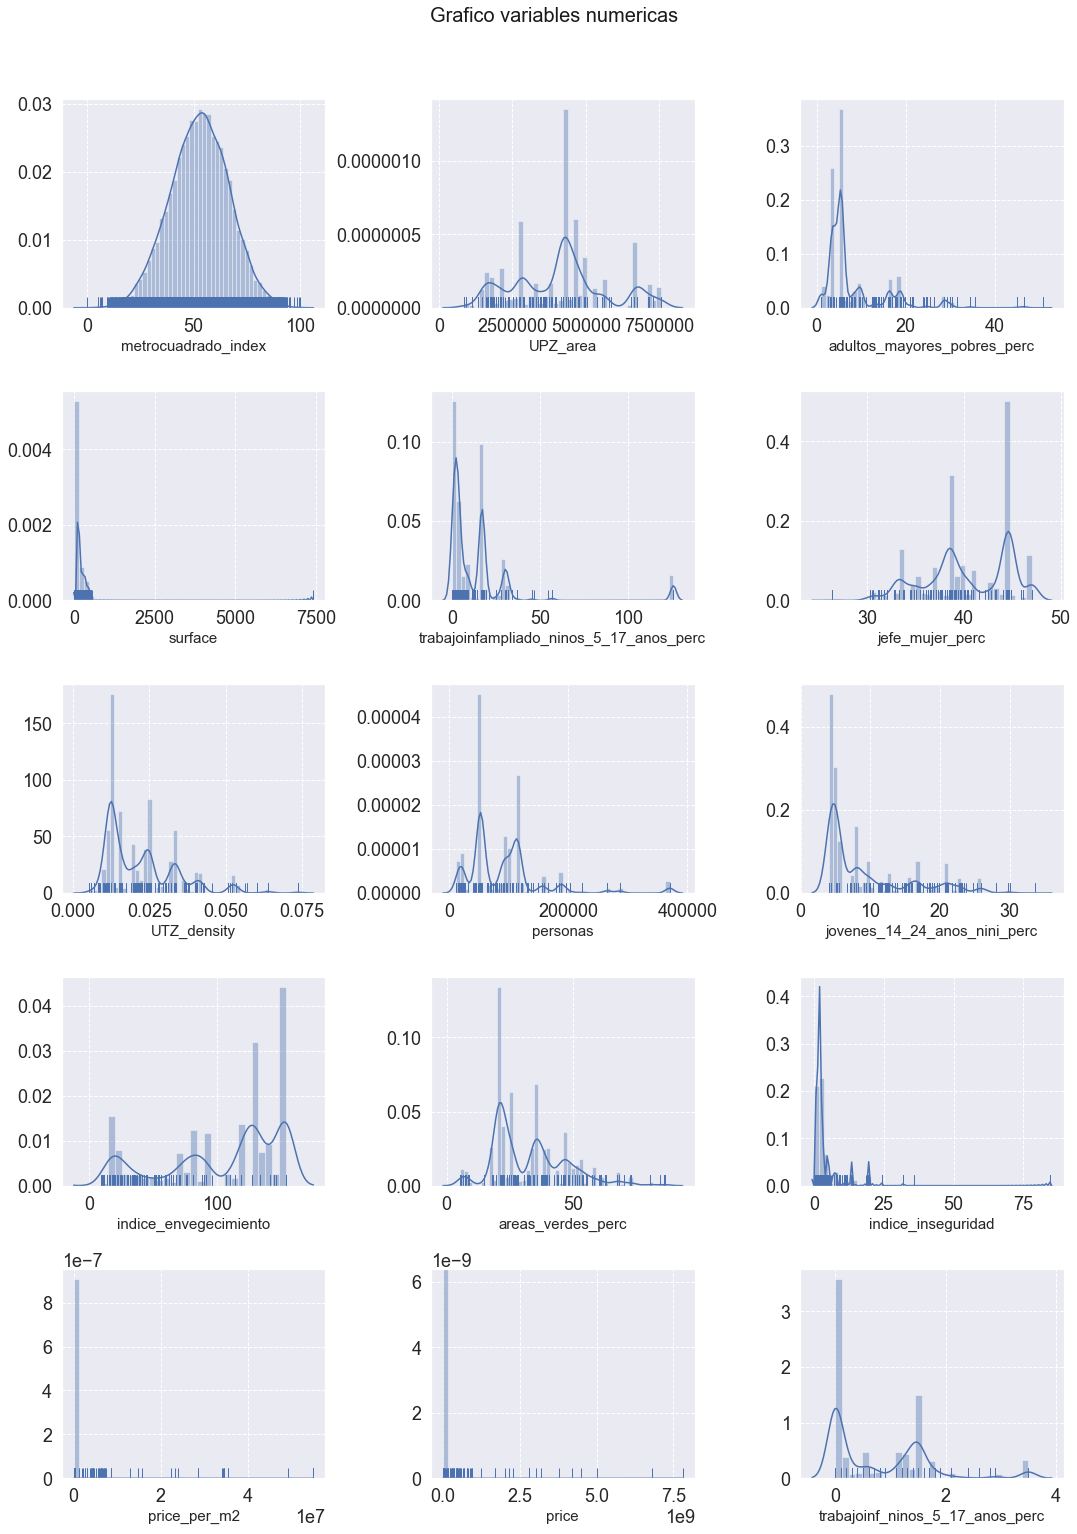

In [36]:
plot_numeric_vars(data,numeric,'Grafico variables numericas')

En primer lugar, sobresale la distribucion de `metrocuadrado_index`. Es la unica que no contiene grandes concentraciones. A simple vista, se podria aproximar con una distribucion Normal. Por otro lado, las variables `price`, `surface`, `indice_inseguridad` y `price_per_m2` presentan grandes concentraciones en zonas especificas. 

Para profundizar el analisis, luego de estudiar las distribuciones de las variables categoricas se estudiaran los comportamientos bivariados: relaciones entre variables con _scatterPlot_ y _violinPlot_. 

A continuacion se muestran las distribuciones de las variables categoricas:

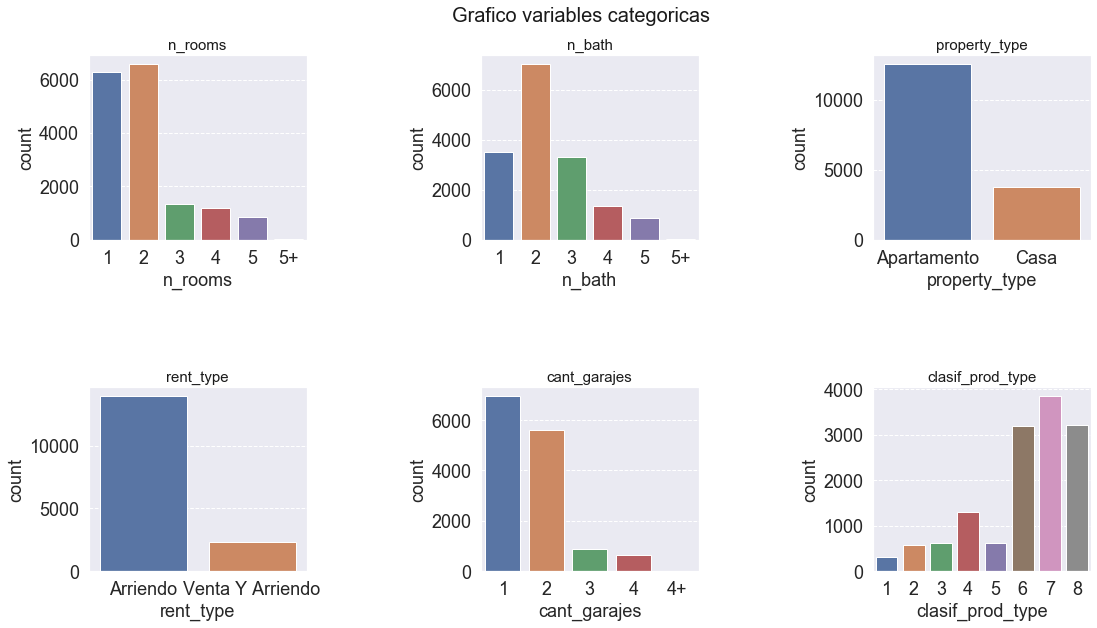

In [37]:
plot_order = {'n_rooms': [ '1', '2', '3', '4', '5', '5+'],
              'n_bath': [ '1', '2', '3', '4', '5', '5+'],
              'property_type': ['Apartamento', 'Casa'],
              'rent_type': ['Arriendo', 'Venta Y Arriendo'],
              'cant_garajes': ['1', '2', '3', '4', '4+'],
              'clasif_prod_type': [i for i in range(1,9)]
             }
plot_categorical_vars(data,categorical,'Grafico variables categoricas',plot_order)
#len(categorical)

De las distribuciones de las variables categoricas, es posible inferir que la variable `rent_type` no aporta mucha informacion al momento de inferir el precio por metro$^2$. Esto debido a la alta concentracion en uno de los valores. Se puede inferir lo mismo de la variable `property_type`. 

Para comprender mejor que informacion me aportan las distintas columnas para resolver el problema, es bueno identificar la varible objetivo o _target_ y hacer graficas comparativas con esta.

Como la variable _target_ es el precio cuadrado por metro cuadrado, a continuacion se implementa una funcion para Estudiar como se relacionan estas variables. Para las variables categoricas, el tipo de grafico utilizado es el boxplot o el grafico de violin. Para las variables numericas se utiliza el _scatter plot_. Dado el rango de precio por $metro^2$, es importante que exista la opcion de escalar el eje y.

In [38]:
def plot_violin(target, col, order = None, scale = False ,df = data):
    '''
    Para variables categoricas v/s una variable target. Las variables categoricas deben ser de baja
    cardinalidad, sino el grafico no es util.
    Genera grafico de violin e histograma con distribucion de la variable a comparar.
    Recibe el nombre de la variable objetivo y la variablecon la cual se desea comparar.
    
    Args:
    --------
    target: String
        Nombre de la columna objetivo (eje y).
    col: String 
        Nombre de la columna que representara el eje x.
    scale: Bool
        Si se quiere o no escalar el eje y. Util cuando el rango de esta variable es muy grande. 
        
    Returns: None
        Muestra en pantalla dos graficos: Violin plot (similar al boxplot) y el histograma de 
        la variable col.
        
    Ejemplo de uso:
    --------------
    plot_violin('price_per_m2','n_rooms')
    '''
    sns.set(rc=custom)
    
    # Sirve para fija el tamaño de lasetiquetas del plot
    fontdict = {'fontsize':20}

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2,1,figsize=[12,13])

    # violin plot --> equivalente a catplot(kind = 'violin')
    if scale:
        sns.violinplot(col,
                    y=(target),
                    data=df,
                    kind='violin',
                    ax=ax[0],
                    order = order).set_yscale("log")
    else:
        sns.violinplot(col,
            y=(target),
            data=df,
            kind='violin',
            ax=ax[0],
            order = order)

    sns.countplot(df[col], ax=ax[1], order = order)

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel(target, fontdict)
    title = 'Violin plot ' + col + ' v/s ' + target
    ax[0].set_title(title, fontdict)
    title_y = "Frecuencias " + col
    ax[1].set_title(title_y, fontdict)
    

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)

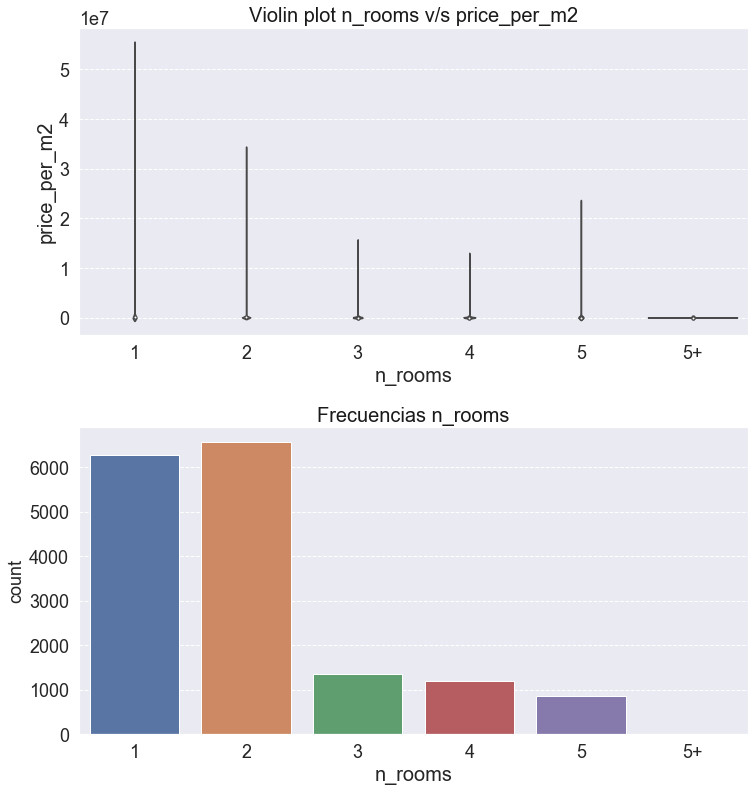

In [39]:
plot_violin('price_per_m2','n_rooms', order = plot_order['n_rooms'])

### Filtrado: 

Observemos que, debido al rango de la variable `price_per_m2`, es dificil obtener visualizaiones buenas de la relacion entre las variables. Por esto, se acotara en adelante el precio por m2 para que este en el rango [10000, 100000]. Esto solo se realizara para las visualizaciones y el perfilamiento. Por esto se creara un nuevo DataFrame `new_data`.  

In [40]:
new_data = data.copy()
new_data = new_data[new_data.price_per_m2 < 100000]
new_data = new_data[new_data.price_per_m2 > 10000]
'''De esta forma tambien es posible eliminar outliers.'''

print('Largo original del DataFrame: ',len(data))
print('Largo del nuevo DataFrame: ', len(new_data))
print('Maximo precio por m2 del nuevo DataFrame: ', max(new_data.price_per_m2))

Largo original del DataFrame:  16305
Largo del nuevo DataFrame:  15963
Maximo precio por m2 del nuevo DataFrame:  96923.07692307692


Verifiquemos que al eliminar las colas de la variable `price_per_m2` se mantiene el mismo rango intercuartil:

In [41]:
from scipy.stats import iqr

data['price_per_m2_nuevo'] = data['price_per_m2'].apply(pd.to_numeric, errors='coerce')

In [42]:
#Para el calculo del rango intercuartil se deben eliminar los 'nan'.
print('Rango intercuartil price_per_m2 data original: ', iqr(data.price_per_m2_nuevo.dropna()))
print('Rango intercuartil price_per_m2 nueva data: ', iqr(new_data.price_per_m2))
print('Diferencia porcentual entre los rangos intercuartiles: ',
      1- iqr(new_data.price_per_m2) / iqr(data.price_per_m2_nuevo.dropna()) )

print('='*100 + '\n' + 'Cantidad de filas eliminadas: ', len(data)- len(new_data))
print('Porcentaje de filas eliminadas: ', 1 - len(new_data)/len(data))

Rango intercuartil price_per_m2 data original:  17598.684210526313
Rango intercuartil price_per_m2 nueva data:  17251.46198830409
Diferencia porcentual entre los rangos intercuartiles:  0.019730010384216068
Cantidad de filas eliminadas:  342
Porcentaje de filas eliminadas:  0.020975160993560227


Al eliminar los `nan` y realizar el recorte en base a `price_per_m2`, se obtiene una diferencia porcentual del rango intercuartil del $2\%$, lo cual para efectos del estudio de graficos sera considerado dentro del rango aceptable. 

Por otro lado, la cantidad de filas que se eliminan corresponden al $2\%$

A continuacion se observa como cambian las distribuciones de las variables `['price','surface','price_per_m2']` luego de aplicar el recorte:

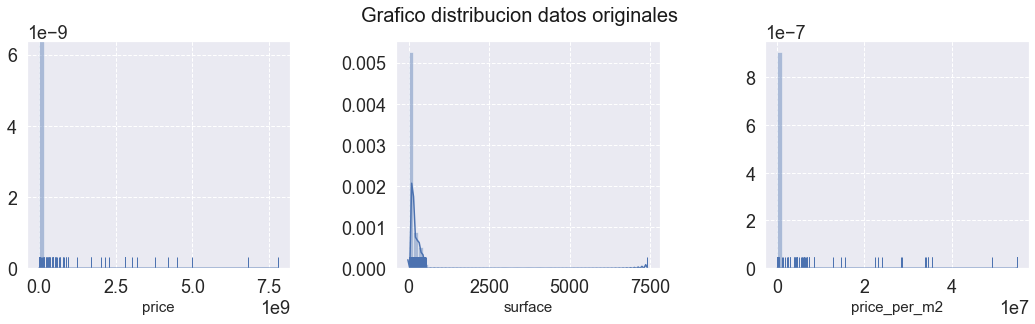

In [43]:
plot_numeric_vars(data,['price','surface','price_per_m2'],'Grafico distribucion datos originales')

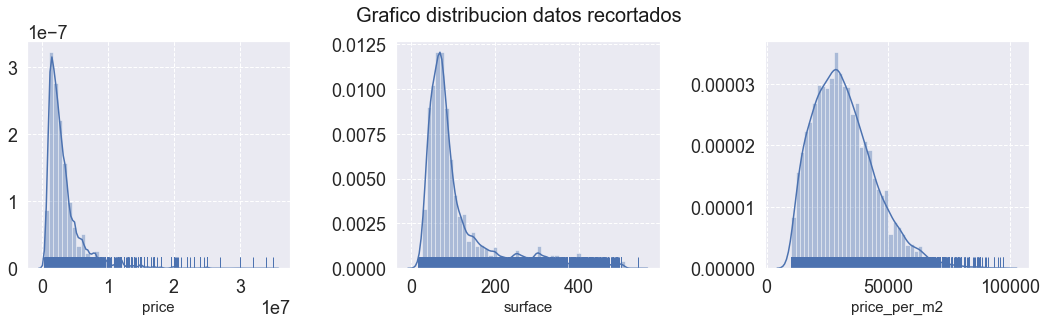

In [44]:
plot_numeric_vars(new_data,['price','surface','price_per_m2'],'Grafico distribucion datos recortados')

Continuamos con los graficos de variables categoricas v/s precio por metro$^2$:

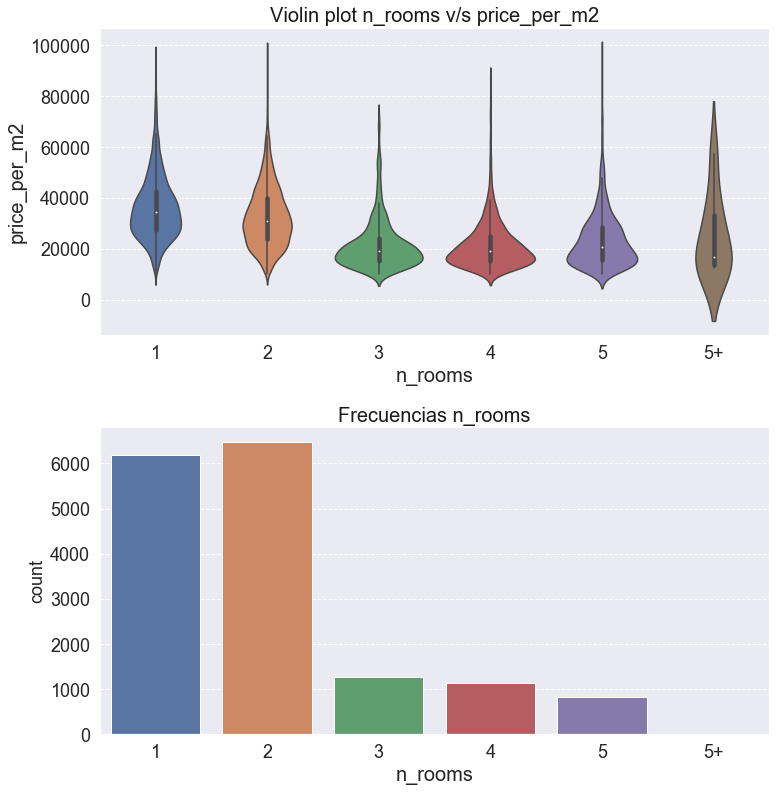

In [45]:
#Grafico para cantidad de piezas vs precio por m2
plot_violin('price_per_m2','n_rooms', order = plot_order['n_rooms'],scale = False ,df = new_data)

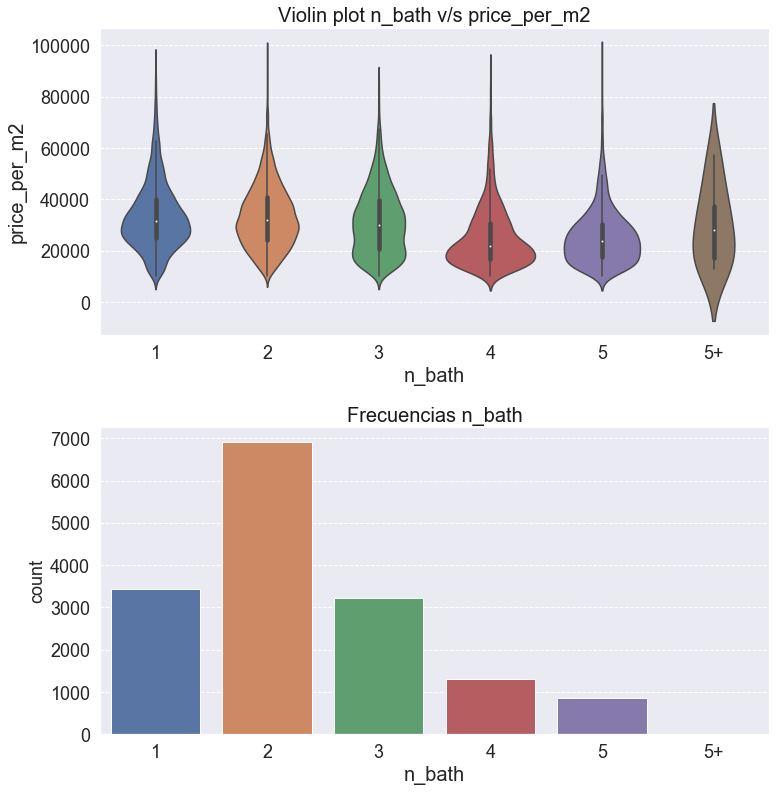

In [46]:
#Grafico para cantidad de piezas vs precio por m2
plot_violin('price_per_m2','n_bath', df = new_data, order = plot_order['n_bath'])

Se observa que, aunque muy leve, existe una relacion entre `price_per_m2` y `n_rooms`. En especial si se toman en cuenta solo los valores pertenecientes a [1, 2, 3, 4, 5] Por otro lado, es claro que las propiedades con 1 y 2 dormitorios son las que predominan.

La variable `n_bath` tiene un comportamiento similar 

Observemos ahora como se relaciona la clasificacion de la propiedad v/s el precio por $metro^2$:

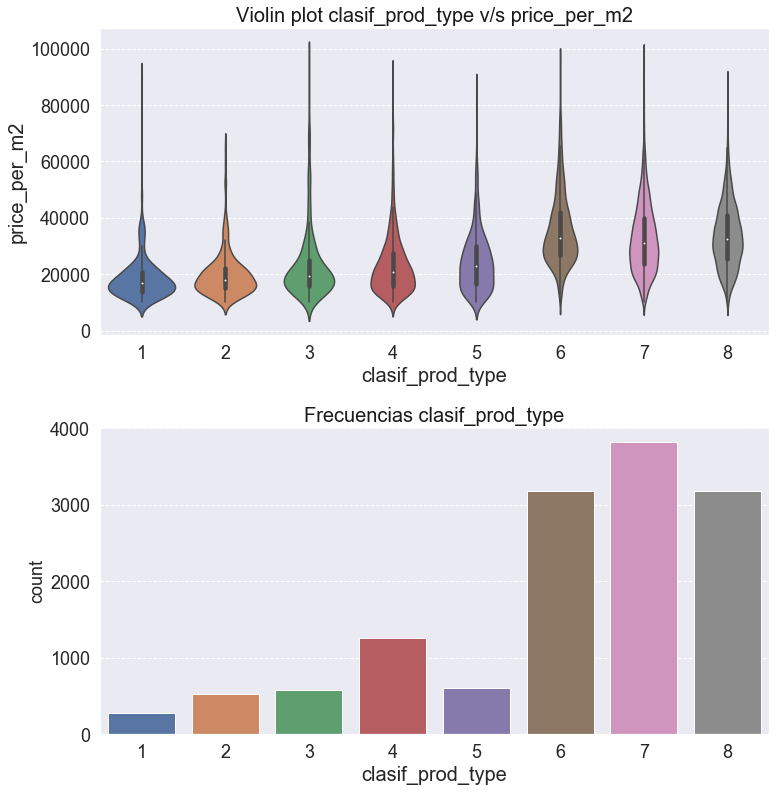

In [47]:
plot_violin('price_per_m2','clasif_prod_type', df = new_data, order = plot_order['clasif_prod_type'])

Como se observa en la primera imagen correspondiente a los graficos de violin, se observa una leve pendiente positiva: a medida que aumenta el numero correspondiente a la clasificacion del producto, aumenta (aunque levemente) el precio por $metro^2$. Esta variable sera de interes mas adelante porque ademas no presenta una concentracion en una clase particular tan alta como en el caso de `n_rooms`. 

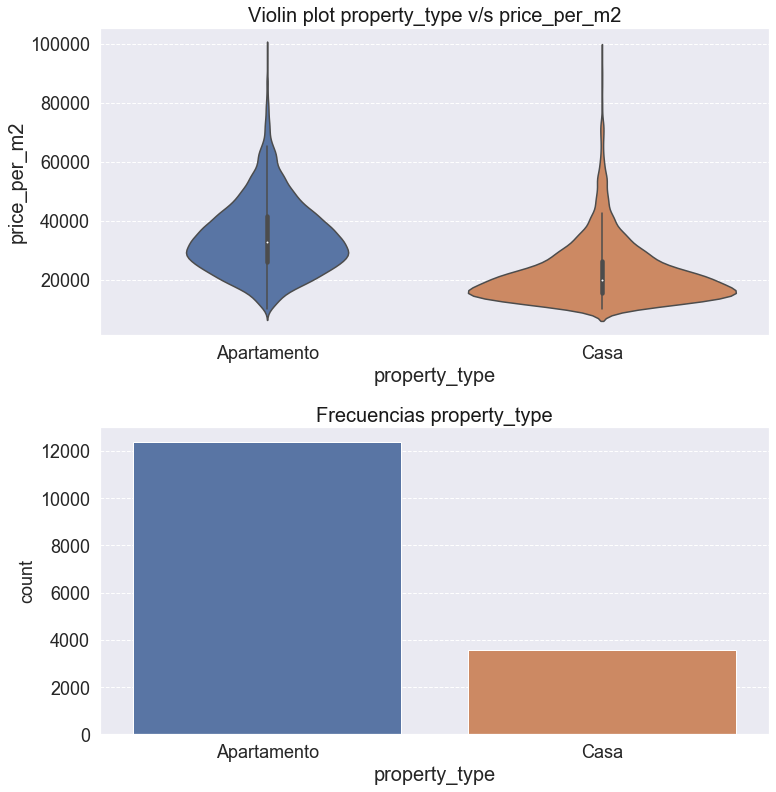

In [48]:
plot_violin('price_per_m2','property_type', df = new_data, order = plot_order['property_type'])

Se observa que el precio por metro$^2$ de apartamento es algo mas caro que el de las casas. Por otro lado, hay una gran diferencia en la cantidad de casas y apartamentos.

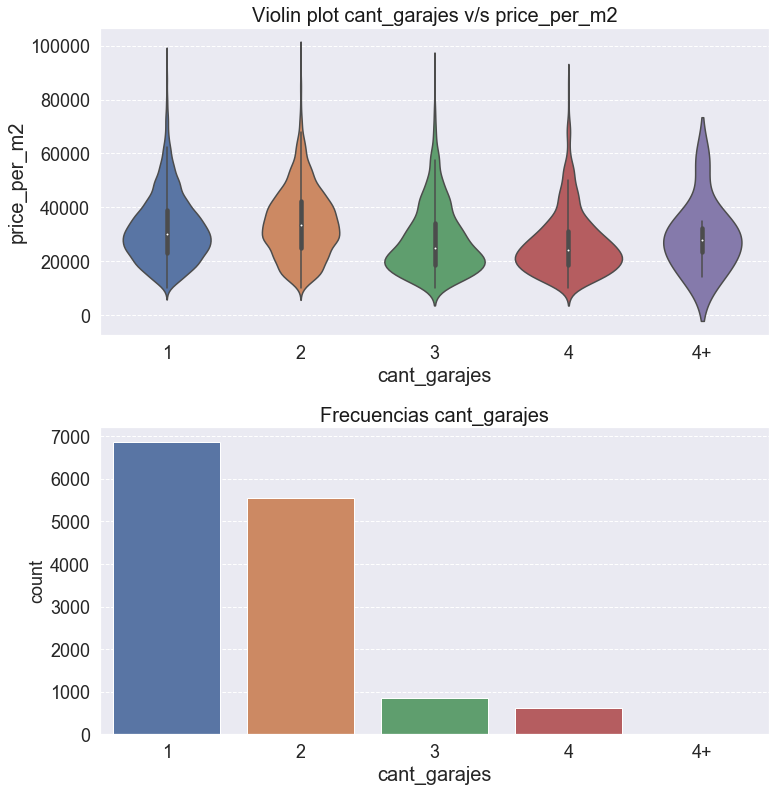

In [49]:
plot_violin('price_per_m2','cant_garajes', df= new_data, order = plot_order['cant_garajes'])

La variable `cant_garajes` tiene un comportamiento muy similar a las variables `n_bath` y `n_rooms`, pero su distribucion esta mas concentrada en 1 y 2.

A continuacion se procede a realizar los mismos graficos: variables numericas v/s precio por metro$^2$:

In [50]:
def plot_scatter(target, col, reg = True, scale = False, df = data):
    '''
    Para variables numericas v/s una variable target. 
    Genera el scatterplot e histograma con distribucion de la variable a comparar.
    Recibe el nombre de la variable objetivo y la variablecon la cual se desea comparar.
    
    Args:
    --------
    target: String
        Nombre de la columna objetivo (eje y).
    col: String 
        Nombre de la columna que representara el eje x.
    reg: Bool
        Si se incluye o no una regresion lineal sobre los datos.
    scale: Bool
        Si se quiere o no escalar el eje y. Util cuando el rango de esta variable es muy grande. 
        
    Returns: None
        Muestra en pantalla dos graficos: Violin plot (similar al boxplot) y el histograma de 
        la variable col.
        
    Ejemplo de uso:
    --------------
    plot_scatter('price_per_m2','price')
    '''
    
    sns.set(rc=custom)
    
    # Sirve para fija el tamaño de lasetiquetas del plot
    fontdict = {'fontsize':20}

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2,1,figsize=[10,10])

    # violin plot --> equivalente a catplot(kind = 'violin')
    if scale:
        if reg:
            sns.regplot(x = col,
                        y= target,
                        data=df,
                        ax=ax[0]).set_yscale("log")
            title = 'Scatter plot ' + col + ' v/s log(' + target + ') con ajuste lineal.'
            ax[0].set_title(title, fontdict,y=1.05)
        else:
            sns.scatterplot(x = col,
                            y=target,
                            data=df,
                            ax=ax[0]).set_yscale("log")
            title = 'Scatter plot ' + col + ' v/s log(' + target + ')'
            ax[0].set_title(title, fontdict,y=1.05)
    else:
        if reg:
            sns.regplot(x = col,
                        y= target,
                        data=df,
                        ax=ax[0])
            title = 'Scatter plot ' + col + ' v/s ' + target + ' con ajuste lineal.'
            ax[0].set_title(title, fontdict,y=1.05)
        else:
            sns.scatterplot(x = col,
                            y=target,
                            data=df,
                            ax=ax[0])
            title = 'Scatter plot ' + col + ' v/s ' + target
            ax[0].set_title(title, fontdict ,y=1.05)

    sns.distplot(df[col], ax=ax[1])

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel(target, fontdict)
    
    title_y = "Frecuencias " + col
    ax[1].set_title(title_y, fontdict,y=1.05)
    

    h, w = (.6, .1)
    plt.subplots_adjust(wspace=w, hspace=h)

Observemos que al fijar un rango para `price_per_m2` y eliminar los datos que sobrepasan este rango, cambia notoriamente la distribucion de `price` y de `surface`. 

A continuacion se muestan los _scatterPlot_ de algunas variables de interes v/s el precio por metro cuadrado. Se observan las variables `metrocuadrado_index`, `indice_envegecimiento`, `UPZ_area`, `UTZ_density` y `jefe_mujer_perc` ya que se observa que son variables poco concentradas. 
Es importante mencionar que las variables `price` y `surface` no se incluyen en el analisis ya que precio por metro$^2$ se construye a partir de estas dos.

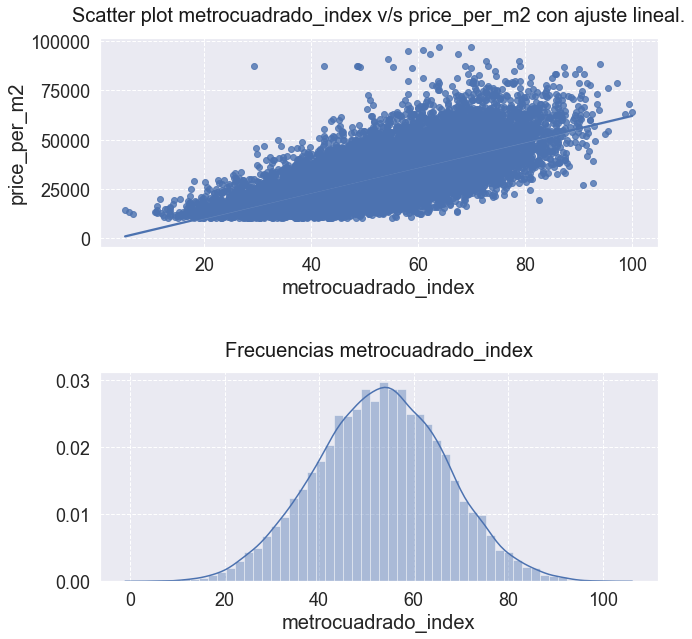

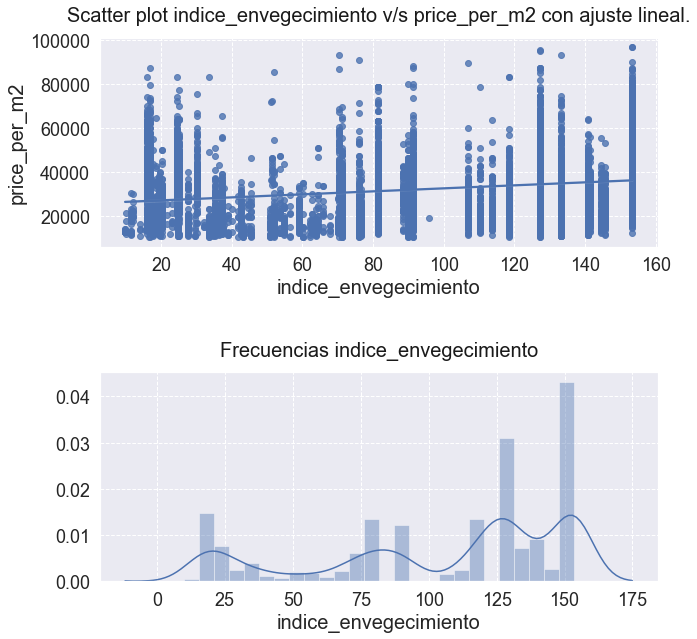

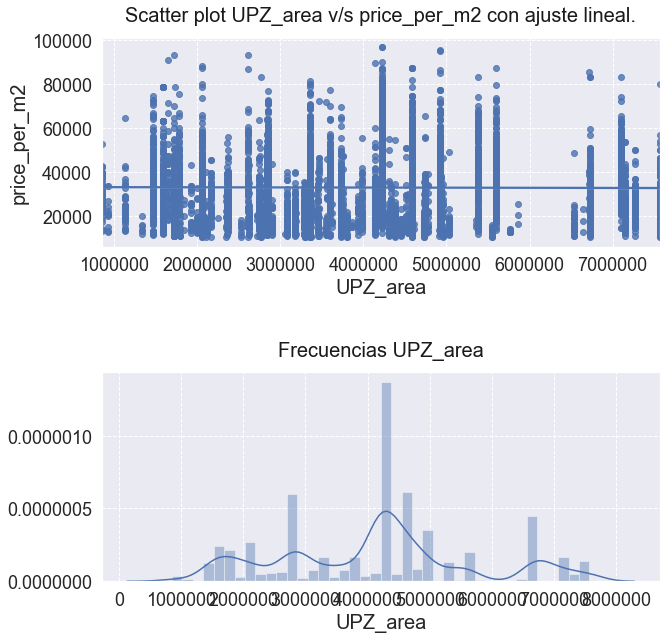

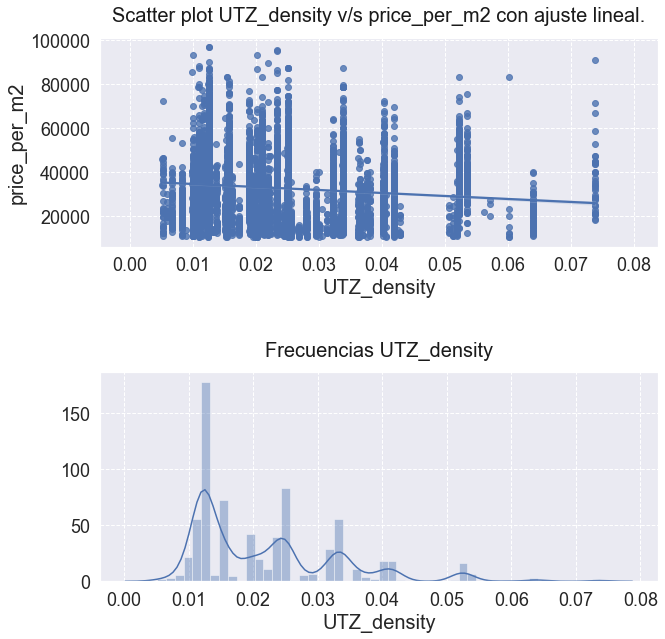

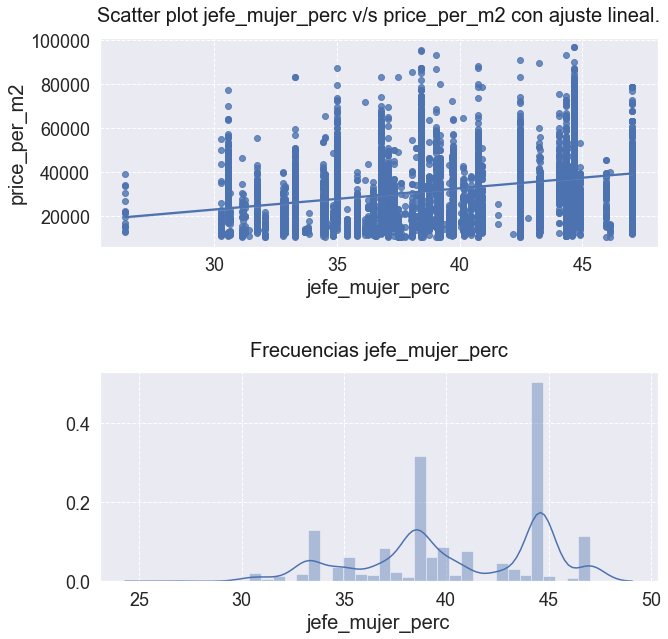

In [51]:
var_de_interes = ['metrocuadrado_index', 'indice_envegecimiento', 'UPZ_area', 'UTZ_density', 'jefe_mujer_perc']
for var in var_de_interes:
    plot_scatter('price_per_m2', var, df = new_data)

De esta forma, se observa una clara relacion lineal entre `metrocuadrado_index` y `price_per_m2`. De igual forma, el ajuste lineal en las variables `jefe_mujer_perc` e `indice_envegecimiento` indican una relacion entre estas y `price_per_m2` pero con una observacion detenida se puede inferir que probablemente no presenten una dependencia lineal entre ellas. De todas formas, debido a que no presentan grandes concentraciones en valores particulares, seguiran siendo de interes mas adelante. 

### Codificacion de columnas tipo categorical y string:
Como se menciono anteriormente, hay un grupo de variables que no se estudio. Estas corresponden a `details`, `url`, `UPZ`, `location`. A continuacion se realizara un estudio breve de `UPZ` y `location`. Para esto, se codificaran las distintas etiquetas como numeros para que sea mas facil realizar graficos. El funcionamiento del _LabelEncoder_ se muestra a continuacion:

```python
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
LabelEncoder()
list(le.classes_)
['amsterdam', 'paris', 'tokyo']
le.transform(["tokyo", "tokyo", "paris"])
array([2, 2, 1]...)
list(le.inverse_transform([2, 2, 1]))
['tokyo', 'tokyo', 'paris']
```

[Fuente ejemplo y documentacion LabelEncoder sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [52]:
#Codificacion de UPZ
from sklearn import preprocessing
import math
new_data.UPZ = new_data['UPZ'].astype('str')

le_UPZ = preprocessing.LabelEncoder()
le_UPZ.fit(new_data.UPZ.unique())

UPZ_code = le_UPZ.classes_
new_data['UPZ_cat'] = le_UPZ.transform(new_data.UPZ)

print('='*20 + '   Codificacion UPZ   ' + '='*20)
print(UPZ_code)
print(le_UPZ.inverse_transform([0,0,1,2,3,4]))

====================   Codificacion UPZ   ====================
['UPZ10' 'UPZ100' 'UPZ101' 'UPZ102' 'UPZ103' 'UPZ104' 'UPZ105' 'UPZ106'
 'UPZ107' 'UPZ108' 'UPZ11' 'UPZ110' 'UPZ111' 'UPZ112' 'UPZ113' 'UPZ114'
 'UPZ115' 'UPZ12' 'UPZ13' 'UPZ14' 'UPZ15' 'UPZ16' 'UPZ17' 'UPZ18' 'UPZ19'
 'UPZ2' 'UPZ20' 'UPZ21' 'UPZ22' 'UPZ23' 'UPZ24' 'UPZ25' 'UPZ26' 'UPZ27'
 'UPZ28' 'UPZ29' 'UPZ30' 'UPZ31' 'UPZ33' 'UPZ34' 'UPZ35' 'UPZ36' 'UPZ37'
 'UPZ38' 'UPZ39' 'UPZ40' 'UPZ41' 'UPZ42' 'UPZ43' 'UPZ44' 'UPZ45' 'UPZ46'
 'UPZ47' 'UPZ48' 'UPZ49' 'UPZ50' 'UPZ53' 'UPZ54' 'UPZ55' 'UPZ57' 'UPZ58'
 'UPZ59' 'UPZ65' 'UPZ66' 'UPZ67' 'UPZ68' 'UPZ69' 'UPZ70' 'UPZ71' 'UPZ72'
 'UPZ73' 'UPZ75' 'UPZ76' 'UPZ77' 'UPZ78' 'UPZ79' 'UPZ80' 'UPZ81' 'UPZ82'
 'UPZ83' 'UPZ84' 'UPZ85' 'UPZ86' 'UPZ87' 'UPZ88' 'UPZ89' 'UPZ9' 'UPZ90'
 'UPZ91' 'UPZ92' 'UPZ93' 'UPZ94' 'UPZ95' 'UPZ96' 'UPZ97' 'UPZ98' 'UPZ99'
 'nan']
['UPZ10' 'UPZ10' 'UPZ100' 'UPZ101' 'UPZ102' 'UPZ103']


In [53]:
#Codificacion de location:
le_location = preprocessing.LabelEncoder()
le_location.fit(new_data.location.unique())

location_code = le_location.classes_
new_data['location_cat'] = le_location.transform(new_data.location)

print('\n'*2 + '='*20 + '   Codificacion Location   ' + '='*20)
print('Location code: ', location_code[25:30])
print(le_location.inverse_transform([123,23,435,4,56]))



====================   Codificacion Location   ====================
Location code:  ['autopista muzu' 'autopista muzu 0riental' 'balcares'
 'balcones de oriente' 'banco central']
['ciudad jardin sur' 'autopista del sur' 'rionegro' 'acevedo tejada'
 'bosque de pinos']


In [54]:
#codificacion property_type:
le_pptype = preprocessing.LabelEncoder()
le_pptype.fit(new_data.property_type.unique())

pptype_code = le_pptype.classes_
new_data['property_type_cat'] = le_pptype.transform(new_data.property_type)

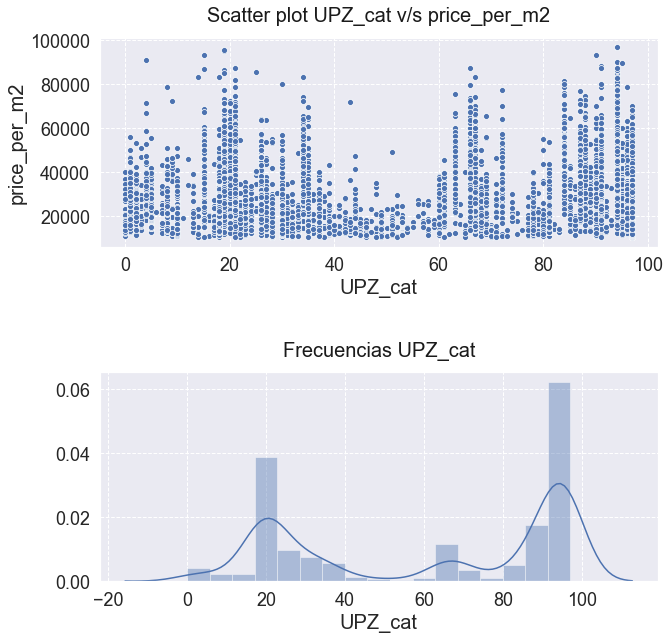

In [55]:
plot_scatter('price_per_m2', 'UPZ_cat', reg = False ,df = new_data)

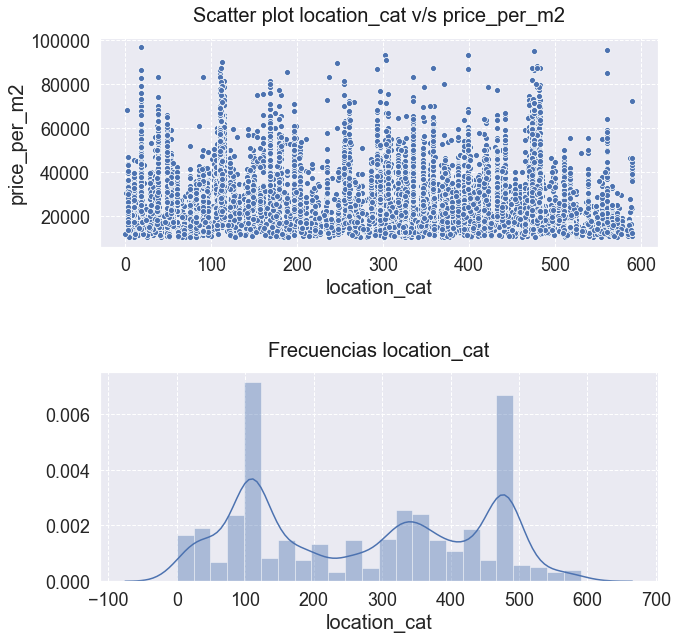

In [56]:
plot_scatter('price_per_m2', 'location_cat', df = new_data, reg = False)

Estudiar comportamiento de las variables `location_cat` y `UPZ_cat` a partir de los graficos no tiene mucho sentido dado que estos representan la codificacion de la variable real. Esto se realizo para facilidad de estudio de correlacion de las variables. 

#### Perfilamiento Bivariado:
Para comenzar el perfilamiento bivariado se emplean visualizaciones a pares. De esta forma podemos observar las relaciones entre las distintas variables.

In [57]:
interes_para_pairplot = ['price_per_m2', 'metrocuadrado_index', 'indice_envegecimiento', 'UPZ_area', 'UTZ_density', 
           'jefe_mujer_perc', 'clasif_prod_type']

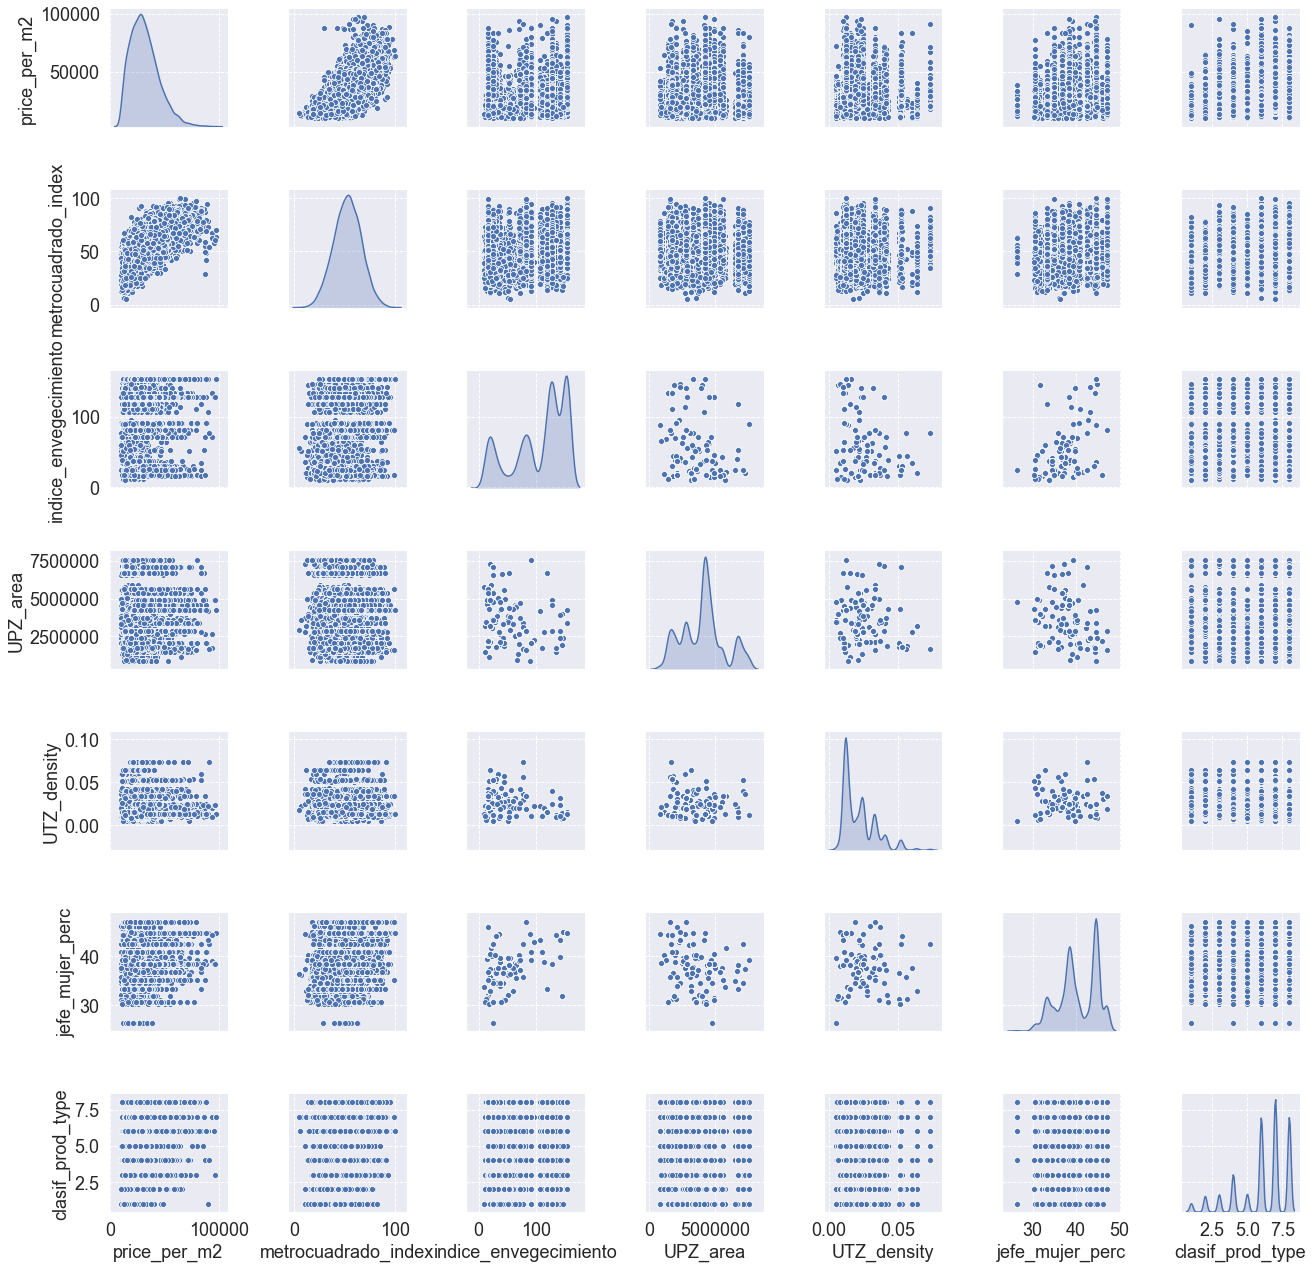

In [58]:
sns.pairplot(data = new_data[interes_para_pairplot], diag_kind='kde')

A vista, la variable que mas llama la atencion como se distribuye es `metrocuadrado_index`. Esta sera de interes en adelante como _feature_ para el regresor. 

### Datos faltantes:
Antes de continuar, se debe realizar un correcto tratamiento de los datos faltantes: 

In [59]:
new_data.isnull().sum()

metrocuadrado_index                           0
UPZ_area                                   1871
adultos_mayores_pobres_perc                1871
surface                                       0
trabajoinfampliado_ninos_5_17_anos_perc    1871
jefe_mujer_perc                            1871
UTZ_density                                1871
personas                                   1871
jovenes_14_24_anos_nini_perc               1871
indice_envegecimiento                      1871
areas_verdes_perc                          1871
indice_inseguridad                         1871
price_per_m2                                  0
price                                         0
trabajoinf_ninos_5_17_anos_perc            1871
n_rooms                                       0
n_bath                                        0
property_type                                 0
rent_type                                     0
cant_garajes                                  0
clasif_prod_type                        

Se observa en primer lugar que todas las columnas que contienen informacion proveniente de los datos en `estadisticas_upz` y en `asignacion_upz` contienen la misma cantidad de datos faltantes. El tratamiento de estos datos faltantes se debe hacer luego de la separacion de datos en conjuntos de _train_ y _test_. Para efectos de las visualizacion y extraccion de caracteristicas se reemplazaran en este momento con el promedio de cada columna. 

Por otro lado, se observa que la columna `clasif_prod_type` tiene una alta cantidad de `nan`. Esto se debe a que hay propiedades que no se encuentran en ninguna de las clasificaciones especificadas en el enunciado. De todas formas, como esta variable se genera a partir de `property_type` y de `surface`, se eliminara esta columna para evitar eliminar 2538 filas (corresponden al 15% de los datos).

Es importante mencionar que la columna `cant_garajes` no contiene `nan` debido a que cuando se contruyo, en las filas donde no habia informacion se asume que era porque la cantidad de garajes es $0$.

In [60]:
new_data = new_data.drop(['clasif_prod_type'], axis = 1)

In [61]:
cols_with_nan = ['jefe_mujer_perc', 'personas', 'indice_inseguridad', 'jovenes_14_24_anos_nini_perc', 'UTZ_density',
                 'trabajoinf_ninos_5_17_anos_perc', 'adultos_mayores_pobres_perc',
                 'trabajoinfampliado_ninos_5_17_anos_perc', 'indice_envegecimiento', 'areas_verdes_perc', 
                 'UPZ_area']
for col in cols_with_nan:
    new_data[col] = new_data[col].fillna(new_data[col].mean())

In [62]:
new_data.isnull().sum()

metrocuadrado_index                         0
UPZ_area                                    0
adultos_mayores_pobres_perc                 0
surface                                     0
trabajoinfampliado_ninos_5_17_anos_perc     0
jefe_mujer_perc                             0
UTZ_density                                 0
personas                                    0
jovenes_14_24_anos_nini_perc                0
indice_envegecimiento                       0
areas_verdes_perc                           0
indice_inseguridad                          0
price_per_m2                                0
price                                       0
trabajoinf_ninos_5_17_anos_perc             0
n_rooms                                     0
n_bath                                      0
property_type                               0
rent_type                                   0
cant_garajes                                0
details                                    99
url                               

### Recategorizar UPZ:
Para realizar la recategorizacion de `UPZ` se utilizo k-means con distinta cantidad de clusters y para elegir con que  cantidad se va a recategorizar, se busca la maxima correlacion de esta nueva variable con `price_per_m2`:

In [63]:
#libreria a utilizar:
from sklearn.cluster import KMeans

#preparacion de los datos para utilizar k-means:
new_data = new_data[~new_data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [64]:
#Como todas las variables categoricas o str se transformaron a numericas, podemos hacer lo siguiente
numeric_new = [col for col in new_data.columns if new_data[col].dtype == 'int32' or new_data[col].dtype == 'float64']

In [65]:
from scipy.stats import pearsonr
def get_cluster(k):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(new_data[numeric_new])


    new_data['k_means']=kmeanModel.predict(new_data[numeric_new])
    
    corr, _ = pearsonr(new_data['price_per_m2'], new_data['k_means'])
    return corr

In [66]:
corr = {}
for i in range(3,6):
    corr[i] = get_cluster(i)

In [67]:
print(corr)

{3: -0.0385343974348108, 4: 0.09378055914753003, 5: 0.08042134979581439}


En base a lo obtenido anteriormente, nos quedaremos con una agrupacion de UPZ en base a k-means con 5 clusters

In [68]:
#Generamos la nueva colummna llamada k-means:
get_cluster(5)

0.23528672507035298

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

axes[0].scatter(new_data['price_per_m2'], new_data['metrocuadrado_index'], c=new_data['UPZ_cat'])
axes[1].scatter(new_data['price_per_m2'], new_data['metrocuadrado_index'], c=new_data['k_means'], cmap=plt.cm.Set1)
axes[0].set_title('UPZ original', fontsize=18)
axes[1].set_title('UPZ agrupado por K-means (5 clusters)', fontsize=18)


Text(0.5, 1.0, 'UPZ agrupado por K-means (5 clusters)')

En los graficos se ve como se relacionan las categorias UPZ originales (codigo de color de la grafica izquierda) con las nuevas obtenidas. 


### Relaciones entre variables:
Para entender como se relacionan las variables entre ellas, se trabajara principalmente con la matriz de correlacion (y el mapa de calor).

In [ ]:
#generamos la matriz de correlacion
corrmat = new_data.corr()

In [ ]:
#correlaciones muy positivas
cols = corrmat.nlargest(15, 'price_per_m2')['price_per_m2'].index 
print('Variables mas correlacionadas con price_per_m2: ' + '\n' + '-'*100)
corrmat[cols].nlargest(7,cols)

Se observa en primer lugar que la variable `metrocuadrado_indice` nos aporta mucha informacion sobre `price_per_m2`. Por otro lado, se vuelve a comprobar que la agrupacion creada para `UPZ`, `k_means`, aporta informacion valiosa para la variable _target_, de hecho tiene un indice de correlacion mayor que la variable `UPZ`.

In [ ]:
cols2 = corrmat.nsmallest(5,'price_per_m2')['price_per_m2'].index
corrmat[cols2].nsmallest(5, cols2).T

A continuacion se muestra el mapa de calor de las variables con correlacion mas alta:

In [ ]:
cm = np.corrcoef(new_data[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 

#### Analisis de eliminacion de outliers:
A continuacion se muestra como se distribuyenen los outliers:

In [ ]:
#Para el calculo del rango intercuartil se deben eliminar los 'nan'.
print('Rango intercuartil price_per_m2 data original: ', iqr(data.price_per_m2_nuevo.dropna()))
print('Rango intercuartil price_per_m2 nueva data: ', iqr(new_data.price_per_m2))
print('Diferencia porcentual entre los rangos intercuartiles: ',
      1- iqr(new_data.price_per_m2) / iqr(data.price_per_m2_nuevo.dropna()) )

print('='*100 + '\n' + 'Cantidad de filas eliminadas: ', len(data)- len(new_data))
print('Porcentaje de filas eliminadas: ', 1 - len(new_data)/len(data))

In [ ]:
new_data = data.copy()
new_data = new_data[new_data.price_per_m2 < 100000]
new_data = new_data[new_data.price_per_m2 > 10000]
'''De esta forma tambien es posible eliminar outliers.'''

print('Largo original del DataFrame: ',len(data))
print('Largo del nuevo DataFrame: ', len(new_data))
print('Maximo precio por m2 del nuevo DataFrame: ', max(new_data.price_per_m2))

In [ ]:
df1 = data[data.price_per_m2 > 100000]
df2 = data[data.price_per_m2<10000]
frames = [df1, df2]
result = pd.concat(frames)


result.UPZ = result['UPZ'].astype('str')

le_UPZ_res = preprocessing.LabelEncoder()
le_UPZ_res.fit(result.UPZ.unique())

UPZ_code_res = le_UPZ_res.classes_
result['UPZ_cat'] = le_UPZ_res.transform(result.UPZ)

In [ ]:
 sns.countplot(result['property_type'])

In [ ]:
sns.distplot(result['UPZ_cat'], rug=True)

In [ ]:
sns.countplot(result['clasif_prod_type'])

### Feature Selection:
En base a las matrices de correlacion y a las variables generadas, las columnas elegidas para la regresion son:
`[metrocuadrado_index, jefe_mujer_perc, price, indice_envegecimiento, k_means, property_type_cat, surface, location_cat, jovenes_14_24_anos_nini_perc]` 

Para comprobar que nuestra eleccion no sea mala, se corroborara con el metodo `SelectKBest` de _sklearn_:

In [ ]:
features_cols = ['metrocuadrado_index', 'jefe_mujer_perc', 'price', 'indice_envegecimiento',
                 'k_means', 'property_type_cat', 'surface', 'location_cat', 'jovenes_14_24_anos_nini_perc']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, chi2
from sklearn import metrics

In [ ]:
data_X_cols = [col for col in new_data.columns if col != 'price_per_m2']

data_X = new_data.dropna()

data_Y = data_X.price_per_m2

data_col = [col for col in numeric if col != 'price_per_m2']
data_X = data_X[data_col]

In [ ]:
# Create and fit selector
selector = SelectKBest(f_regression, k=10)
selector.fit(data_X, data_Y)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = data_X.iloc[:,cols]


In [ ]:
feature_cols_SelectKBest = features_df_new.columns

## Implementación

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from scipy.stats import multivariate_normal


def get_m_N(beta, S_N, X, y):
    return beta * S_N.dot(X.T.dot(y))

def get_S_N(alpha, beta, X):
    sum1 = beta * X.T.dot(X)
    n = sum1.shape[0]
    sum2 = alpha * np.identity(n)
    total_sum = sum1 + sum2
    return np.linalg.inv(total_sum)

def get_alpha(gamma, m_N):
    return gamma / (m_N.T.dot(m_N))

def get_beta(N, gamma, y, m_N, X):
    to_sum = (y - m_N.dot(X.T)) ** 2
    to_inv = to_sum.sum() / (N - gamma)
    return 1. / to_inv

def get_gamma(lambdas, alpha):
    """
    nos devuelve el gamma pedido
    :param lambdas: valores propios necesarios
    :param alpha: alpha a usar
    :return: gamma que se devuelve
    """
    return np.array([i / (alpha + i) for i in lambdas]).sum()

def get_lambdas(beta, X):
    """
    Devuelve los valores propios necesarios
    :param beta: beta a usar
    :param X: X de entrada
    :return: array con lambdas
    """
    M = beta * X.T.dot(X)
    return np.linalg.eig(M)[0]

def get_cov(beta, X, S_N, x):
    pass

def convergence(new, old, tol):
    test = np.abs(new - old) / old
    if test <= tol:
        return True
    else:
        return False

class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):

    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.tol = tol
        self.maxiter = maxiter

        self.alpha = None
        self.beta = None
        self.gamma = None
        self.m_N = None
        self.S_N = None
        self.lambdas = None

    def get_posteriori(self, X, y, alpha, beta):        
        s_N = get_S_N(alpha, beta, X)
        m_N = get_m_N(beta, n_S_N, X, y)
        mu = m_N.T.dot(X)
        cov = 1 / beta + (X.T.dot(S_N.dot(X)))
        return mu, cov
        
        
    def fit(self, X, y):
        X=X
        y = y.values.reshape(-1)
        #valores iniciales
        N = X.shape[1]
        c_lambdas = get_lambdas(self.beta_0, X)
        c_alpha = self.alpha_0
        c_beta = self.beta_0
        c_gamma = get_gamma(c_lambdas, c_alpha)
        c_S_N = get_S_N(c_alpha, c_beta, X)
        c_m_N = get_m_N(c_beta, c_S_N, X, y)

        # while loop
        i = 0
        while i < self.maxiter:
            i += 1
            if i%10 == 0:
                print('iteracion', i, 'de', self.maxiter)
            n_lambdas = get_lambdas(c_beta, X)
            n_alpha = get_alpha(c_gamma, c_m_N)
            n_beta = get_beta(N, c_gamma, y, c_m_N, X)
            n_gamma = get_gamma(n_lambdas, n_alpha)
            n_S_N = get_S_N(n_alpha, n_beta, X)
            n_m_N = get_m_N(n_beta, n_S_N, X, y)

            bool_alpha = convergence(n_alpha, c_alpha, self.tol)
            bool_beta = convergence(n_beta, c_beta, self.tol)
            bool_gamma = convergence(n_gamma, c_gamma, self.tol)

            if bool_alpha and bool_beta and bool_gamma:
                self.alpha = n_alpha
                self.beta = n_beta
                self.gamma = n_gamma
                self.m_N = n_m_N
                self.S_N = n_S_N
                self.lambdas = n_lambdas
                break

            c_alpha = n_alpha.copy()
            c_beta = n_beta.copy()
            c_gamma = n_gamma.copy()
            c_S_N = n_S_N.copy()
            c_m_N = n_m_N.copy()

        self.alpha = n_alpha
        self.beta = n_beta
        self.X = X
        self.y = y

    def predict(self, X, return_std=False):
        mu, var = self.get_posteriori(self.X, self.y, self.alpha, self.beta)
        if return_std == True:
            return mu, cov
        return mu


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
# pipelines
cat_pipe = Pipeline(steps=[('encode', OneHotEncoder())])
std_pipe = Pipeline(steps=[('std_transform', StandardScaler())])
poly_pipe = Pipeline(steps=[('poly', PolynomialFeatures(3))])
minmax_pipe = Pipeline(steps=[('minmax', MinMaxScaler())])
input_pipe = Pipeline(steps=[('input', SimpleImputer(missing_values=np.nan, strategy='mean'))])


cols_X = ['n_rooms', 'n_bath', 'metrocuadrado_index', 
          'property_type', 'rent_type', 'location', 
          'cant_garajes', 'clasif_prod_type', 'UPZ', 
          'trabajoinf_ninos_5_17_anos_perc',
          'trabajoinfampliado_ninos_5_17_anos_perc', 
          'jovenes_14_24_anos_nini_perc', 
          'indice_envegecimiento', 'jefe_mujer_perc', 
          'adultos_mayores_pobres_perc', 
          'indice_inseguridad','areas_verdes_perc', 
          'UTZ_density']











# columnas
cat_cols = ['property_type', 'rent_type', 'location', 'UPZ', ]
num_cols = ['n_rooms', 'n_bath', 'metrocuadrado_index', 'cant_garajes', 
            'trabajoinf_ninos_5_17_anos_perc','trabajoinfampliado_ninos_5_17_anos_perc', 
            'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento','jefe_mujer_perc', 
            'adultos_mayores_pobres_perc', 'indice_inseguridad', 'areas_verdes_perc', 
            'UTZ_density']

for i in num_cols:
    new_data[i] = pd.to_numeric(data[i], errors='coerce')


# ¡Transformers, más de lo que ves!
col_transformer = ColumnTransformer(transformers=[('cat', cat_pipe, cat_cols),
                                                  ('poly', poly_pipe, num_cols),
                                                  ('minmax', minmax_pipe, num_cols)])



In [ ]:
col_transformer.fit_transform(Data)

In [ ]:
from sklearn.model_selection import train_test_split
cols_y = ['price_per_m2']
cols_X = ['n_rooms', 'n_bath', 'metrocuadrado_index', 
          'property_type', 'rent_type', 'location', 
          'cant_garajes', 'UPZ', 
          'trabajoinf_ninos_5_17_anos_perc',
          'trabajoinfampliado_ninos_5_17_anos_perc', 
          'jovenes_14_24_anos_nini_perc', 
          'indice_envegecimiento', 'jefe_mujer_perc', 
          'adultos_mayores_pobres_perc', 
          'indice_inseguridad','areas_verdes_perc', 
          'UTZ_density']

X = new_data.dropna()[cols_X]
X = col_transformer.fit_transform(X)
y = new_data.dropna()[cols_y]

# ojo que hay nans
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predictor = Pipeline(steps=[('predictor', RegresionBayesianaEmpirica(1e-6,1e-6))])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

fitted_model = predictor.fit(X_train, y_train)



In [ ]:
y_pred = fitted_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_2 = r2_score(y_test, y_pred)

In [ ]:
from sklearn.linear_model import BayesianRidge

sklearn_bayesian = BayesianRidge()
modelo_sklearn = sklearn_bayesian.fit(X_train, y_train)
modelo_sklearn_y = modelo_sklearn.predict(X_test)
rmse_sk = np.sqrt(mean_squared_error(y_test, modelo_sklearn_y))
r_2_sk = r2_score(y_test, modelo_sklearn_y)

In [ ]:
import pickle 

with open('modelo.pk', 'wb') as f:
    pickle.dump(fitted_model, f)
f.close()

In [ ]:
! git add .

In [ ]:
! git commit -m "ultimo commit"

In [ ]:
! git push